In [26]:
import pandas as pd
import numpy as np
from re import T
from sklearn.metrics import mean_squared_error
from math import sqrt
#from pomegranate import MarkovChain

id=0

############ load and digitize the data
data=pd.read_csv('/home/ebotian/MCM/tennis.csv')

############

############# pre-process the data
    # fill nan with 0, and replace AD with 50
def pre_process(data):
    data = pd.get_dummies(data, columns=['winner_shot_type','serve_width','serve_depth','return_depth'])
    data = data.fillna(0)
    data = data.replace('AD', 50.0)
    data['point_victor']=data["point_victor"].replace(2,0)
    #print(data.iloc[:,15])

    # split the data into different match
    grouped = dict(tuple(data.groupby(data['match_id'].ne(data['match_id'].shift()).cumsum())))

    # Rename the subdata
    subdata = {df['match_id'].iloc[0]: df for _, df in grouped.items()}

    # Create a new dataset from the first column, excluding duplicates
    match = pd.DataFrame(data.iloc[:, 0].drop_duplicates()).iloc[:,0].tolist()
    return subdata,match

subdata,match=pre_process(data)
#print(subdata[match[1]])
##############

def process_all_ids(subdata):
    for id in range(len(match)-1):
        index_array = subdata[match[id]][subdata[match[id]]['server'] == 2].index.values
        subdata[match[id]].loc[index_array, 'point_victor'] = 1 - subdata[match[id]].loc[index_array, 'point_victor']
        target=pd.DataFrame(subdata[match[id]]["point_victor"])
        # Add the "elapsed_time" column to the "target" DataFrame
        subdata[match[id]]['elapsed_time'] = pd.to_timedelta(subdata[match[id]]['elapsed_time'])
        target.insert(0, 'elapsed_time', subdata[match[id]]['elapsed_time'])
        target['elapsed_time'] = target['elapsed_time'].dt.total_seconds()
        #subdata[match[id]]=subdata[match[id]].drop(columns=["point_victor"])
        features=subdata[match[id]].drop(columns=["point_victor"]).iloc[:,4:]

    return target,features,subdata,index_array

# Replace with your actual match ids
target,features,subdata,index_array=process_all_ids(subdata)
#print(subdata[match[1]])
##############
##############
#invert the victor when the server is 2 to get server_victor
#and after the prediction, we invert the victor again
# Get the index array


# Invert the values in the "point_victor" column for the specified rows

#print(index_array)
##############
# Calculate the time difference between consecutive rows
def get_average_interval(id, subdata):

    # Calculate the time difference between consecutive rows
    subdata[match[id]]['time_diff'] = subdata[match[id]]['elapsed_time'].diff()

    # Calculate the 5th and 95th percentiles
    lower_threshold = subdata[match[id]]['time_diff'].quantile(0.05)
    upper_threshold = subdata[match[id]]['time_diff'].quantile(0.95)

    # Exclude the top 5% and bottom 5% of periods
    filtered_diff = subdata[match[id]]['time_diff'][(subdata[match[id]]['time_diff'] > lower_threshold) & (subdata[match[id]]['time_diff'] < upper_threshold)]

    # Calculate the average of the remaining intervals
    average_interval = filtered_diff.mean()

    return average_interval

def create_markov_chain(id, subdata):
    # Create a new list to store the combined states
    states = []

    # Iterate over the rows in the dataframe
    for index, row in subdata[match[id]].iterrows():
        # Combine the 'server' and 'point_victor' columns and add the result to the list
        states.append(str(row['server']) + "-" + str(row['point_victor']))

    # Build the Markov Chain
    mc = MarkovChain.from_data(states)

    return mc

# Usage:
#mc = create_markov_chain(0, subdata)
#print(mc)
print(subdata[match[id]].columns)

                match_id           player1            player2 elapsed_time  \
300  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     00:00:00   
301  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     00:00:36   
302  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     00:00:58   
303  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     00:01:52   
304  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     00:02:32   
..                   ...               ...                ...          ...   
496  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     03:10:52   
497  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     03:11:31   
498  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     03:12:05   
499  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     03:12:44   
500  2023-wimbledon-1302  Alexander Zverev  Matteo Berrettini     03:13:32   

     set_no  game_no  point_no  p1_sets  p2_sets  p1_games  ...

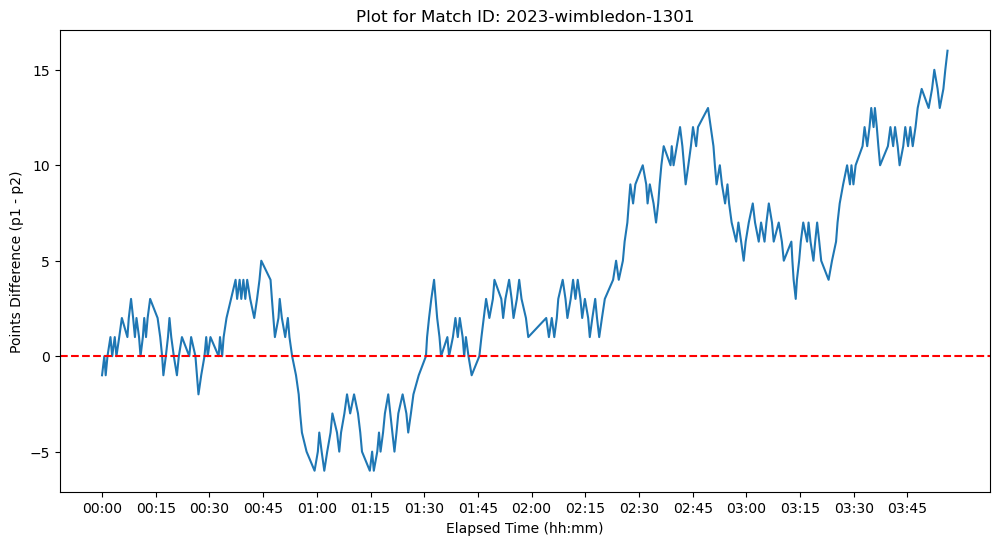

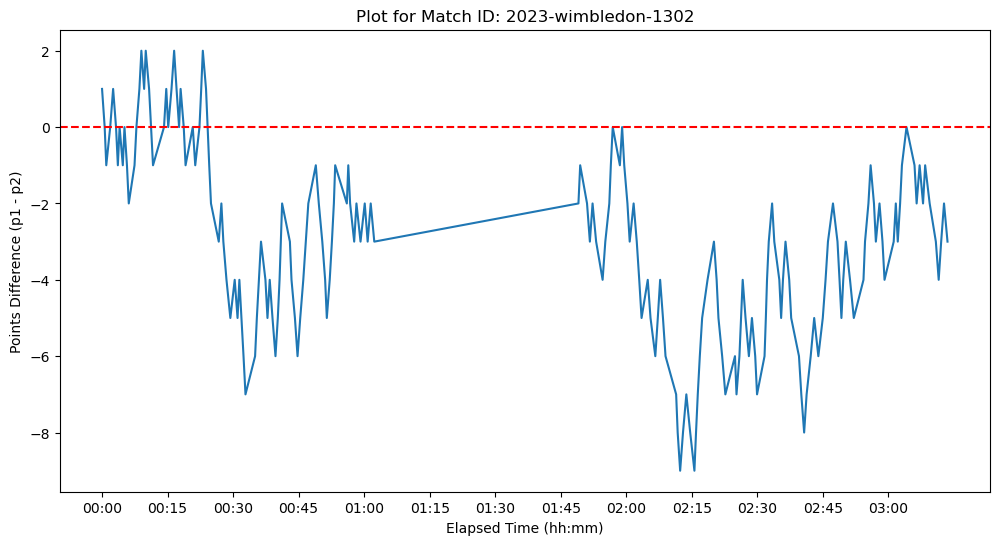

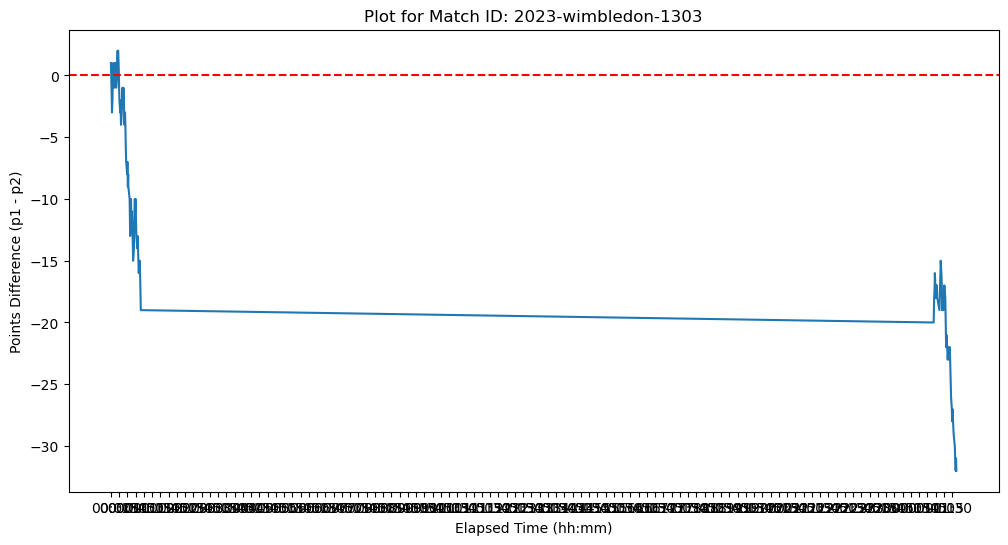

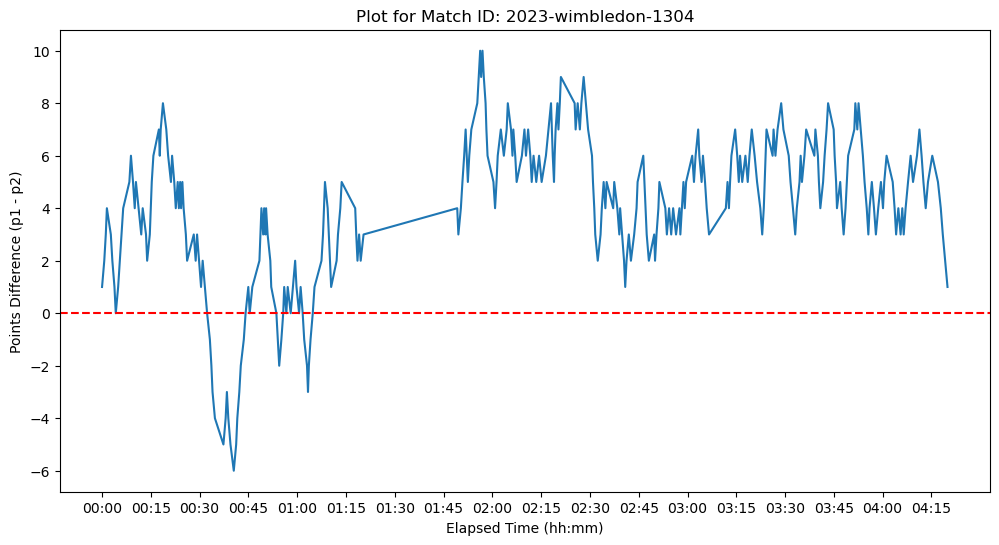

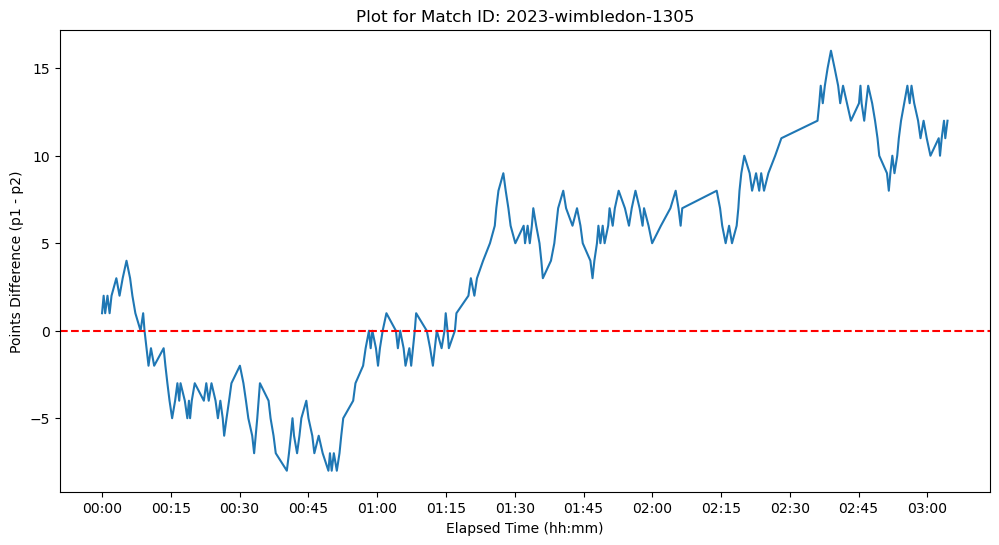

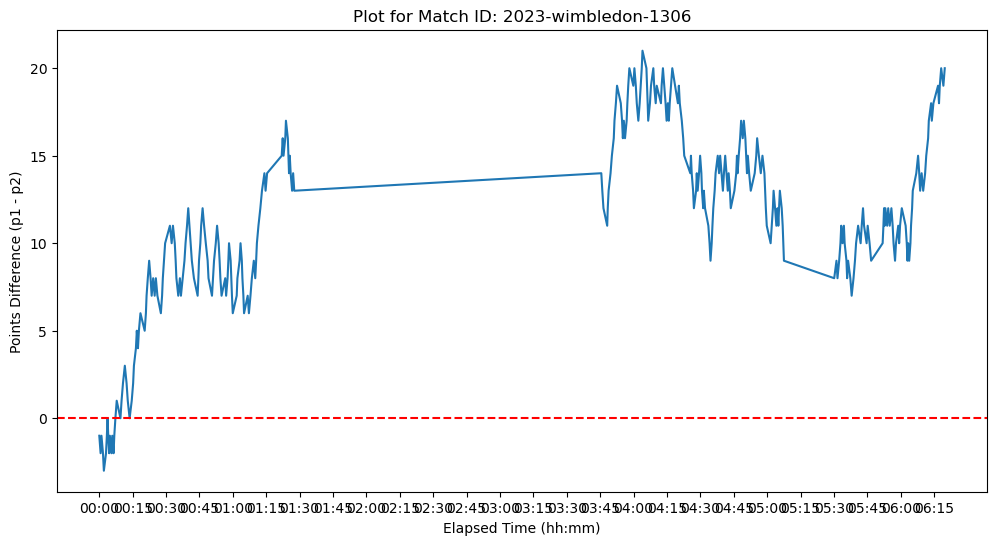

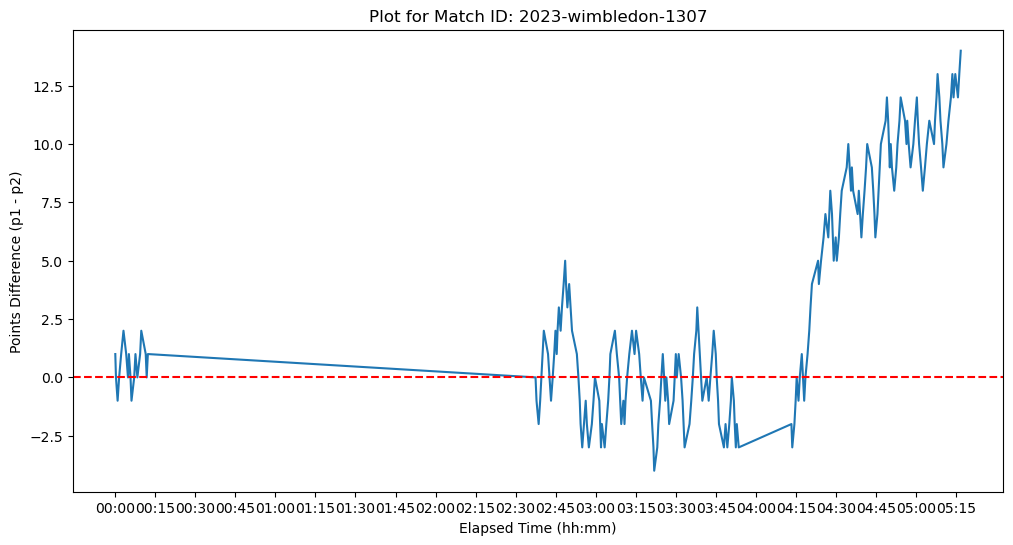

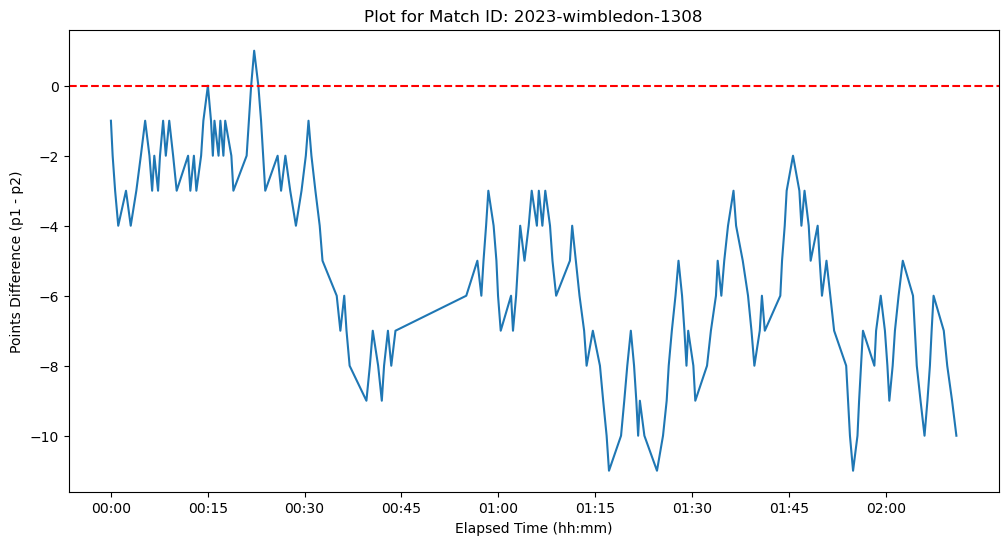

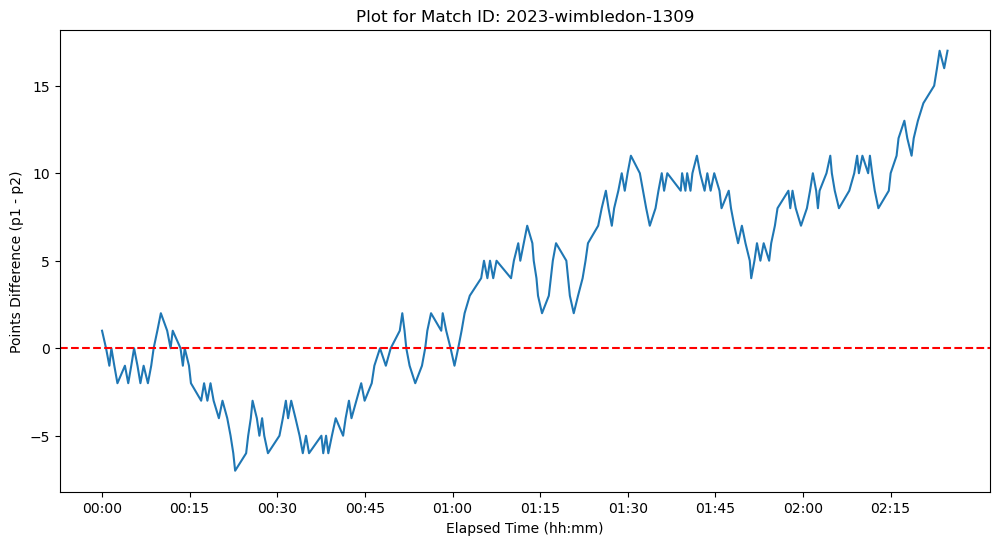

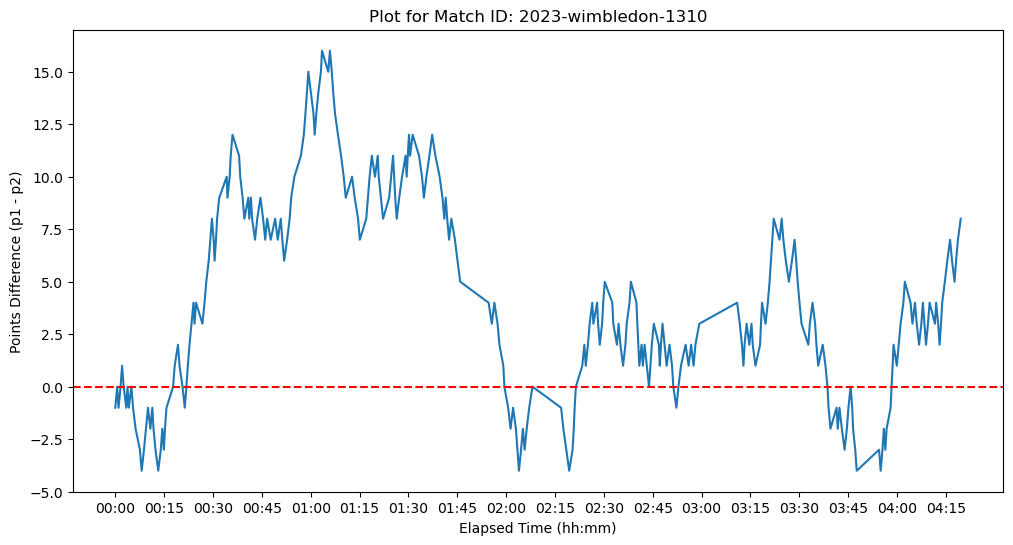

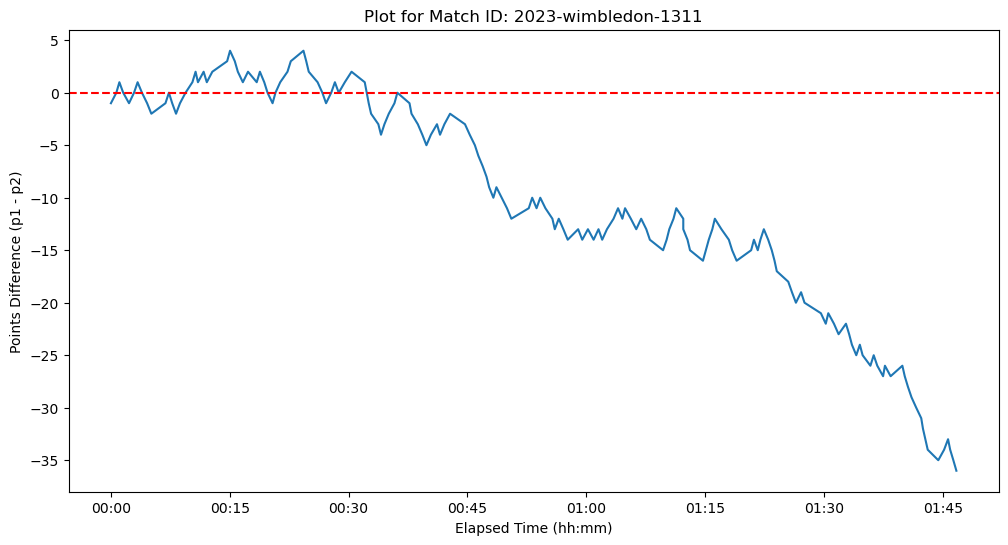

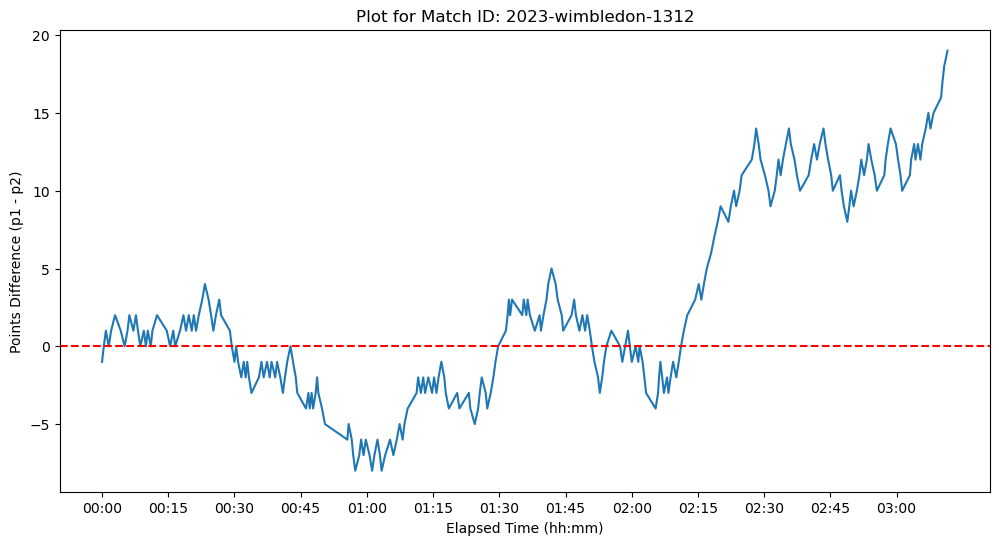

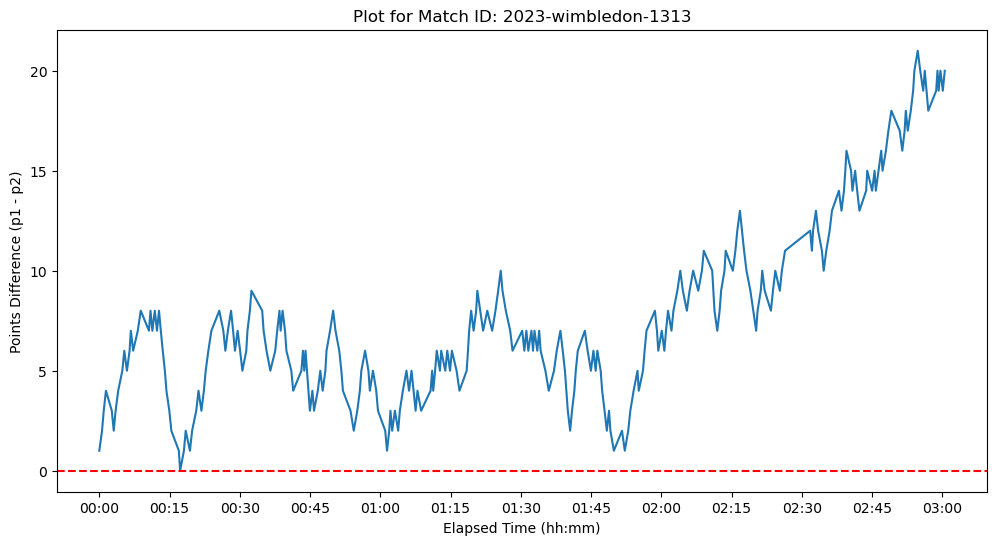

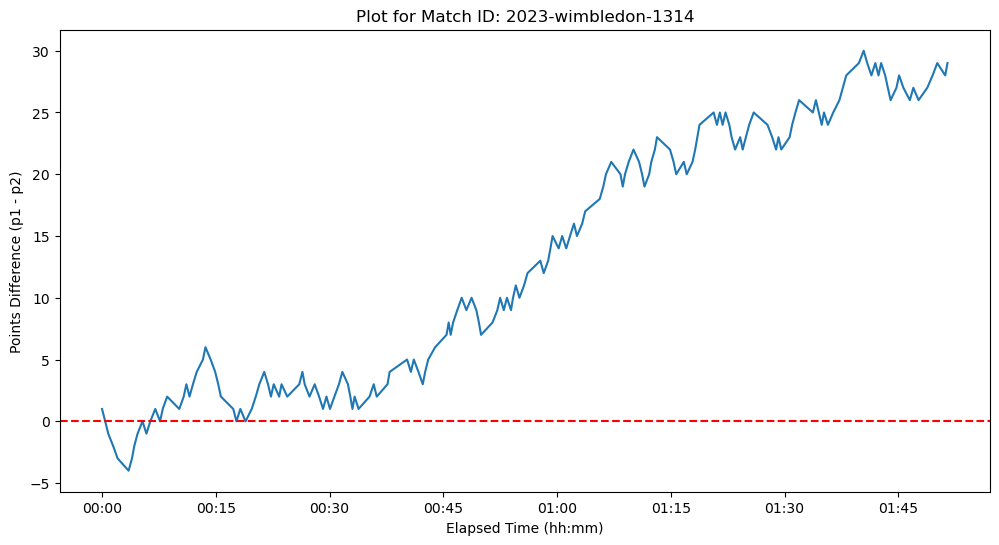

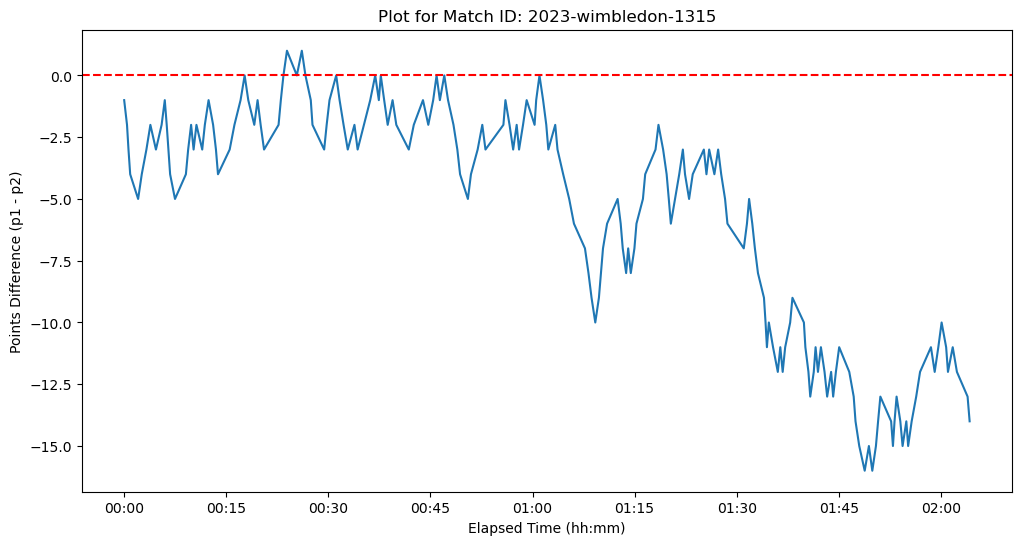

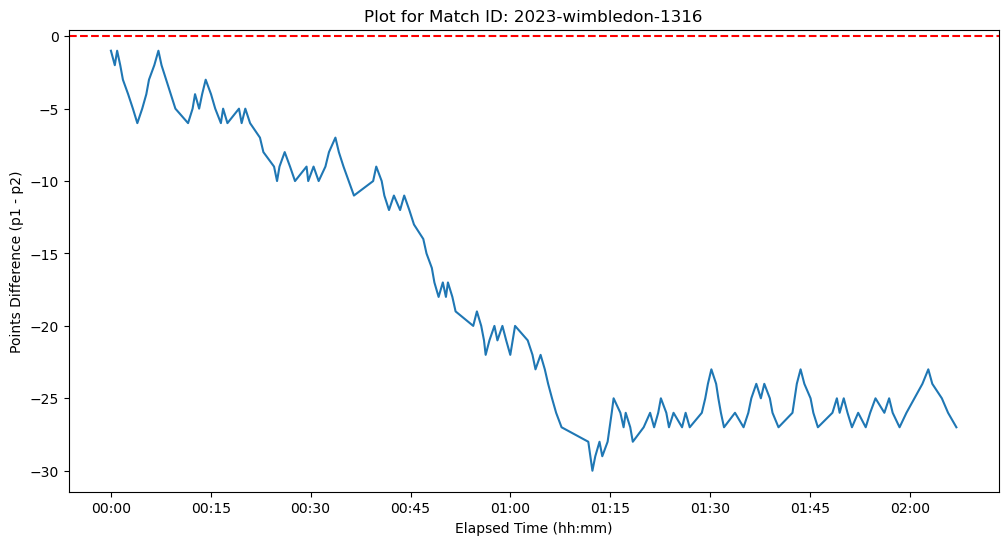

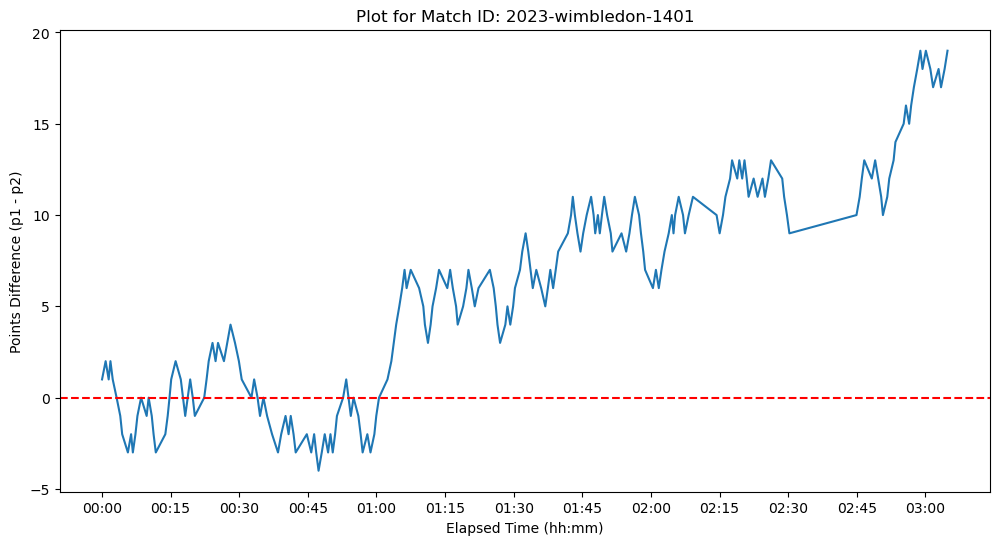

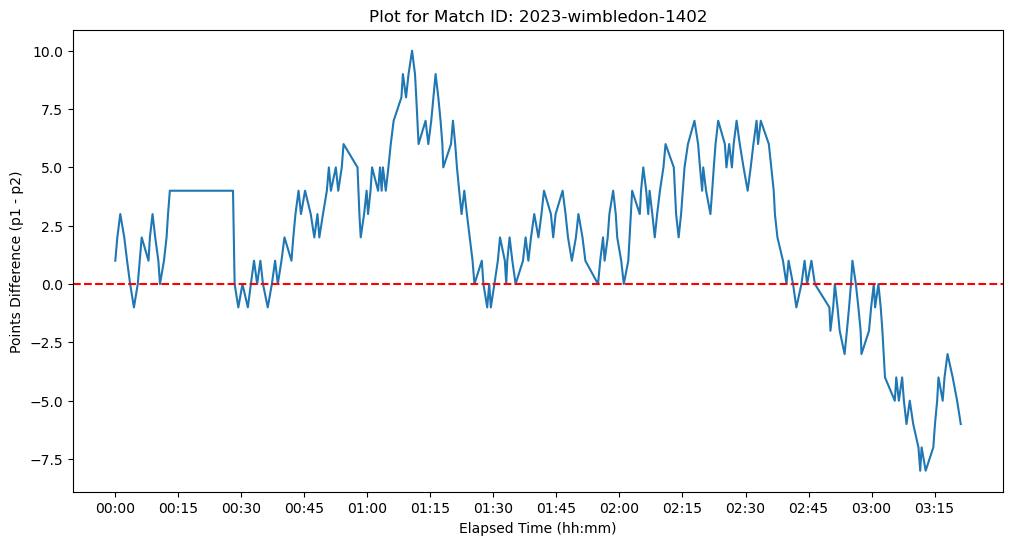

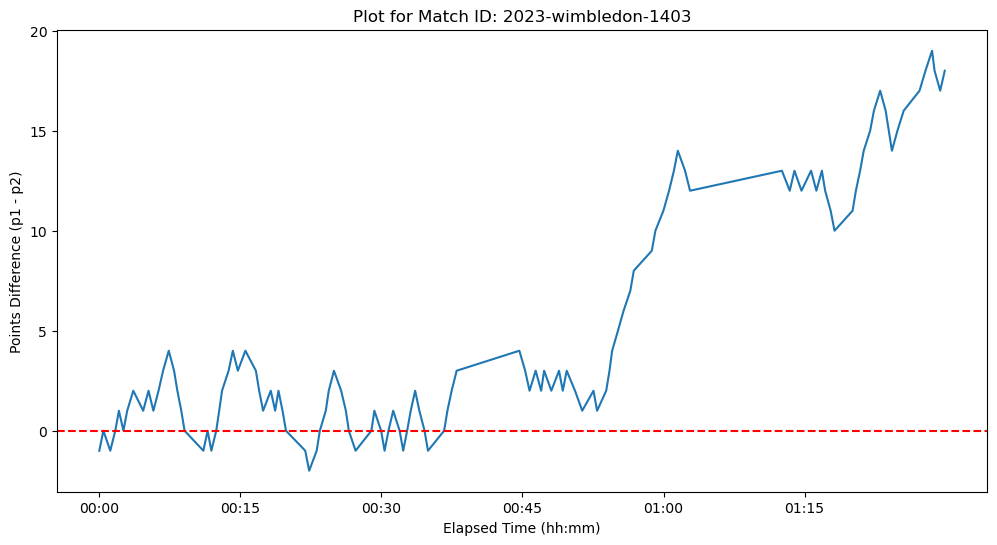

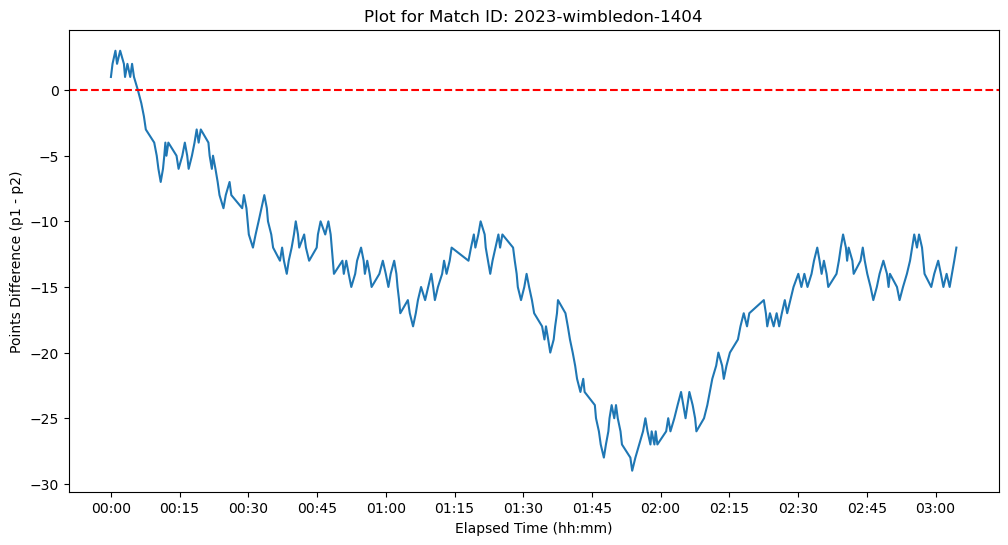

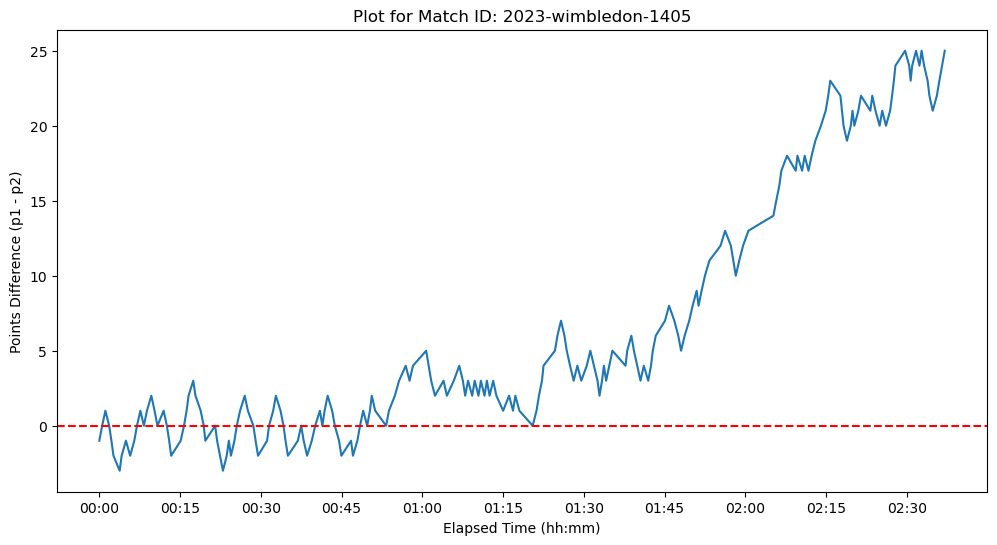

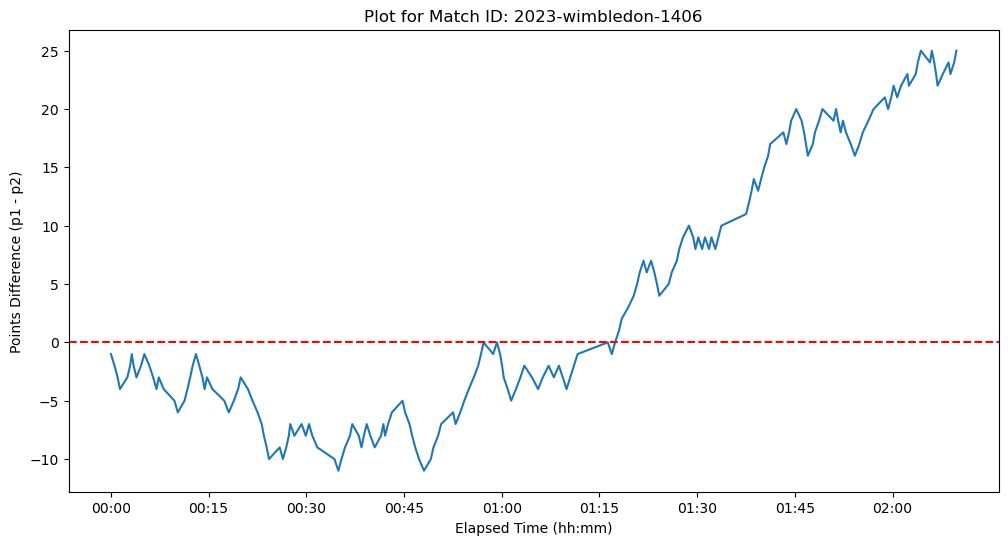

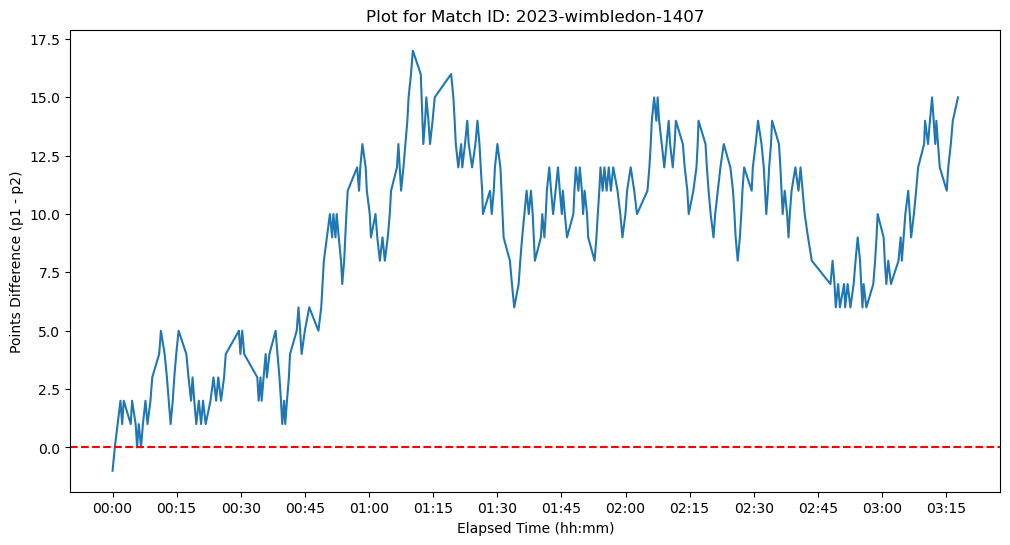

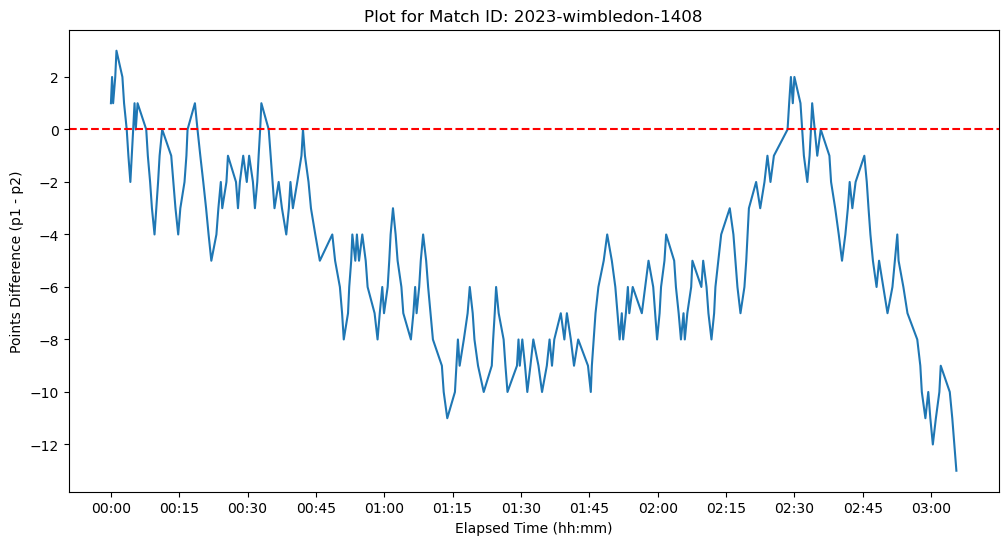

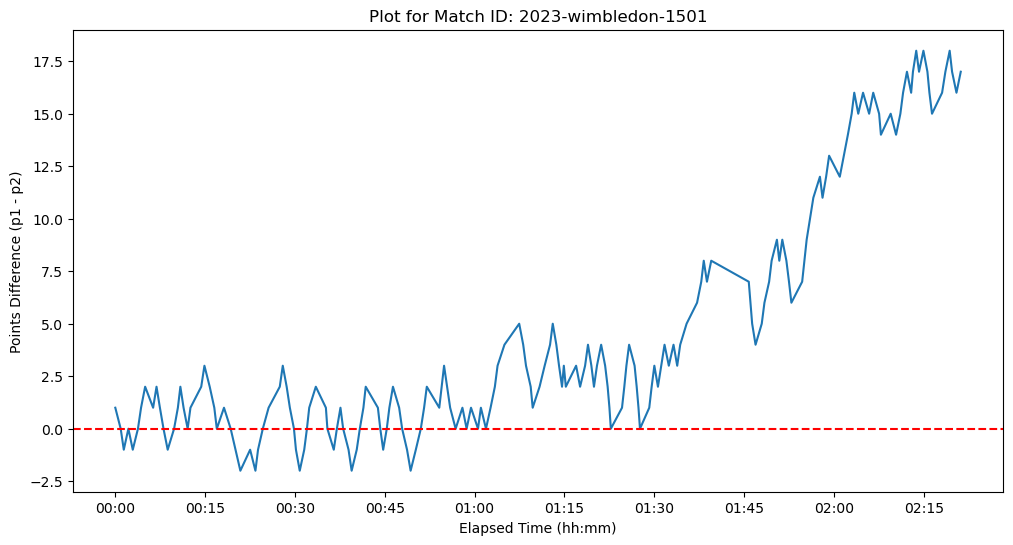

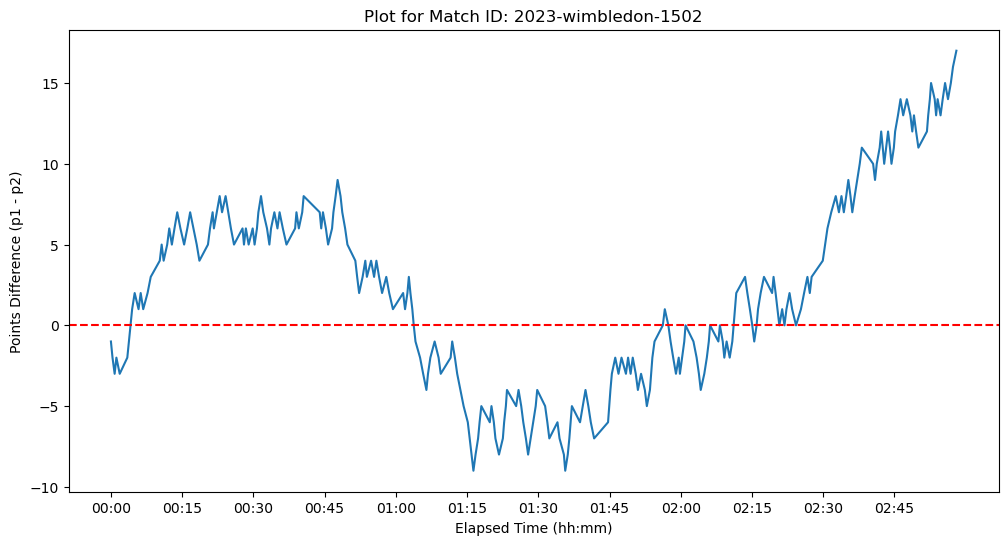

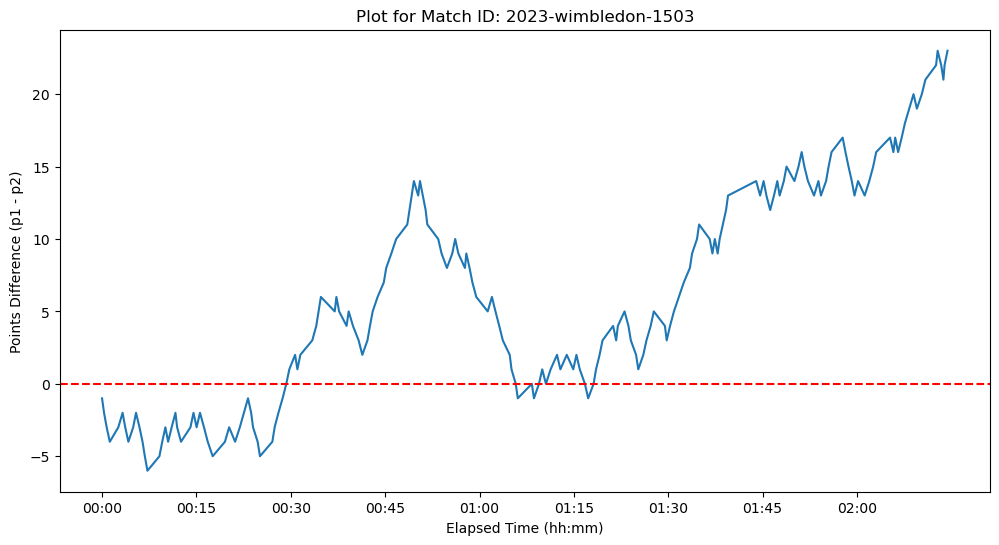

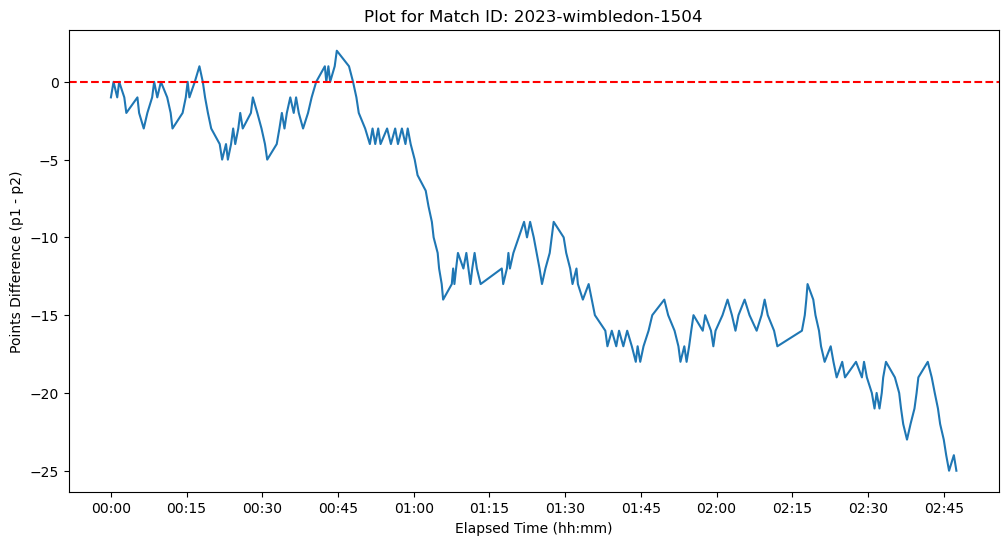

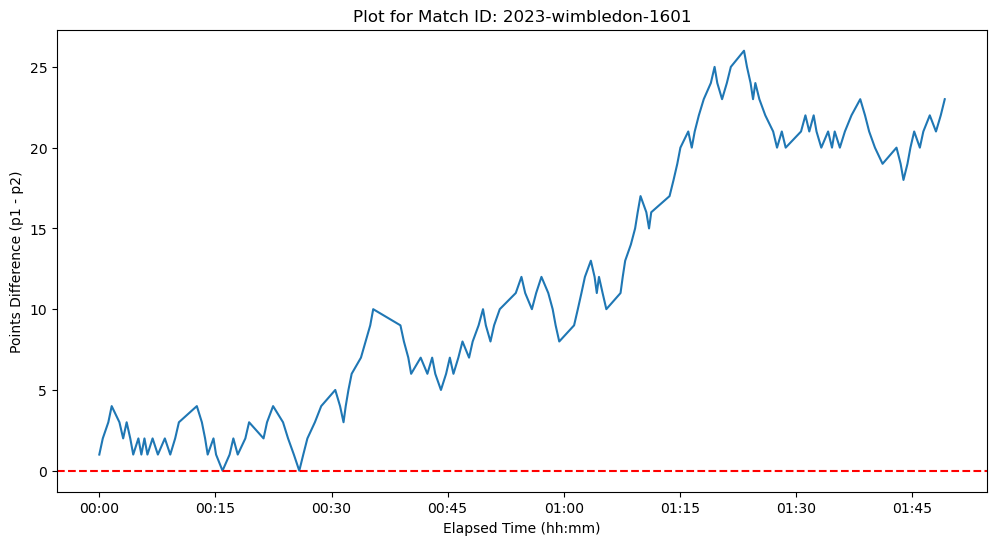

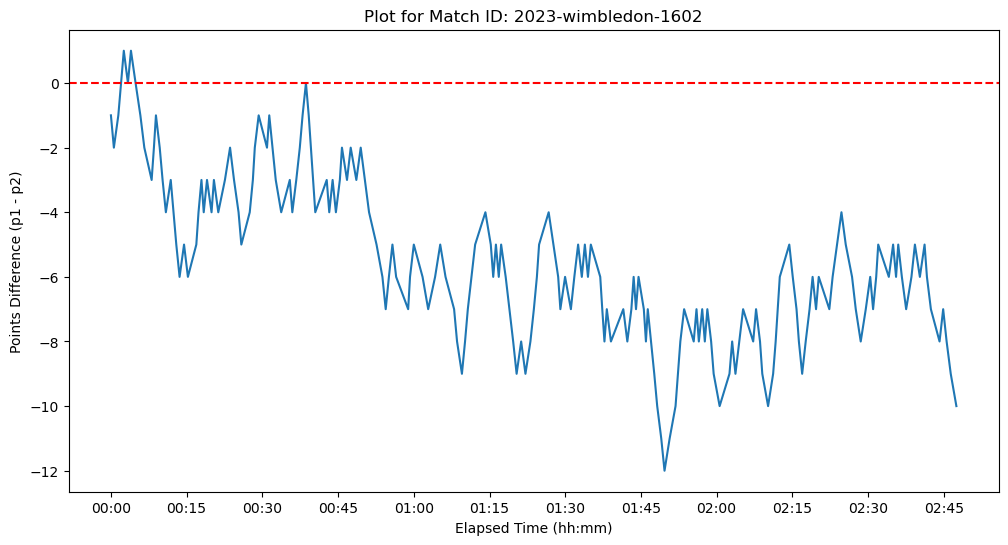

In [29]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def draw_bar_plot(id, subdata):
        # Set the figure size (width, height)
    plt.figure(figsize=(12, 6))

    # Calculate the number of 1s subtracted by the number of 0s in 'point_victor'
    y_values = subdata[match[id]]['p1_points_won'] - subdata[match[id]]['p2_points_won']
    #print(y_values)
    # Get the 'elapsed_time' values and convert them to total number of seconds
    x_values = subdata[match[id]]['elapsed_time'].dt.total_seconds()
    #print(x_values)
    # Create the bar plot
    plt.plot(x_values, y_values)

    # Create xticks every 15 minutes
    x_ticks = np.arange(min(x_values), max(x_values), 15*60)  # 15 minutes in seconds
    x_tick_labels = [(datetime.min + timedelta(seconds=s)).time().strftime('%H:%M') for s in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

        # Add x and y labels
    plt.xlabel('Elapsed Time (hh:mm)')
    plt.ylabel('Points Difference (p1 - p2)')

        # Add a title
    plt.title(f'Plot for Match ID: {match[id]}')

    # Add a horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--')

    # Show the plot
    plt.show()

# Usage:
for id in range(len(match)-1):
    #print(id)
    draw_bar_plot(id, subdata)